# Simple TF tutorial

In [1]:
import numpy as np
import tensorflow as tf

## Tensors of different type

** CONSTANT **

In [ ]:
a = tf.constant(3.0, dtype=tf.float32)
b = tf.constant(4.0) # also tf.float32 implicitly
total = a + b

In [ ]:
print(a)
print(b)
print(total)

tf.Tensor only represents the operation that will be run  

Each operation in the graph has its unique name. The name is independent from the name they have in python.

In [ ]:
sess = tf.Session()  # you need to create a session and run the graph to see the values 

print(sess.run(a))
print(sess.run(b))
print(sess.run(total))

In [ ]:
print(sess.run({'a, b':(a, b), 'total':total}))  # you can evaluate more than one value at the same time

** PLACEHOLDERS **

Super-useful in training, when you want to pass data to your minimization algorithm  

You do not have to specify the dimension of placeholders

In [ ]:
x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)
z = x + y

Again, these three lines are like functions. we need to feed them using numerical values, in order to compute the output z

In [ ]:
print(sess.run(z, feed_dict={x: 3, y: 4.5}))
print(sess.run(z, feed_dict={x: [1, 3], y: [2, 4]}))  # we can pass more than one value at the same time

** VARIABLES **

Here the initialization is necessary

In [ ]:
wk = tf.Variable(tf.random_normal([10,1]))  

we must give the initialization value during the declaration  

**Suggestion: initialize just before running the graph!  ** 

global_variables_initializer only initializes variables that existed in the graph when the initializer was created. So the initializer should be one of the last things added during graph construction.

the following command are necessary once you have defined you our graph

In [ ]:
sess = tf.Session()

# sess.run(wk)  # it's not going to work

In [ ]:
sess = tf.Session()

init = tf.global_variables_initializer()
sess.run(init)

sess.run(wk)  # it's not going to work

## Vanilla example: linear classifier

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

### Our data set: the law generating the data

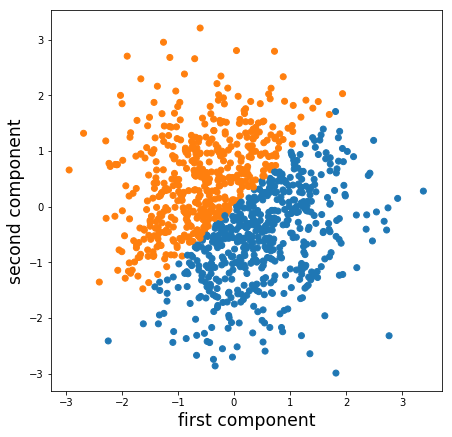

In [14]:
n = 1000    # samples
d = 2      # features

X = np.random.randn(n, d)  
W = np.random.randn(d)
Y = np.sign(X.dot(W))

fig, ax = plt.subplots(figsize=(7,7))
plt.scatter(X[:,0], X[:,1], color=["C0" if Y[i]==1 else "C1" for i in range(n)])
ax.set_xlabel("first component", fontsize="xx-large");
ax.set_ylabel("second component", fontsize="xx-large");

### Define placeholders, variable and stuff

In [15]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[n,d], name="input")
y = tf.placeholder(tf.float32, shape=[n, 1], name="output")

true_value = W
init_value = np.random.randn(d, 1)
w = tf.Variable(init_value, dtype=tf.float32, name="w")

In [16]:
print("init value ", init_value.reshape(-1,))
print("true value ", true_value)

('init value ', array([1.51740699, 0.99888436]))
('true value ', array([ 1.3631595, -1.4002148]))


### Define the model

In [17]:
model = tf.matmul(x, w)                                      # we fit a linea model (cheating a bit)
loss = tf.losses.mean_squared_error(y, model)                # loss function 
grad_step = 2e-3                                             # gradient step
optimizer = tf.train.GradientDescentOptimizer(grad_step)     # optimizer
train = optimizer.minimize(loss)                             # training
init_op = tf.global_variables_initializer()                  # initialize all variables

**tf.losses**, **tf.optimizers** modules  

lots of options! Choose the one you prefer :)

### Define what you want to visualize - NECESSARY IF YOU WANT TO USE TENSORBOARD NEXT

In [18]:
tf.summary.histogram("w", w)
tf.summary.scalar("loss", loss)
merge_summaries = tf.summary.merge_all()
writer = tf.summary.FileWriter('./newgraph/tfmodel0')
writer.add_graph(tf.get_default_graph())

### Run the graph 

In [19]:
with tf.Session() as sess:                                   # start the session - implement the graph
    sess.run(init_op)                                        # build the variables
    for f in range(1000):                                    # iterations: training
        s = sess.run(merge_summaries, {x: X, y:Y.reshape(-1,1)})
        writer.add_summary(s, f)
        sess.run(train, {x: X, y:Y.reshape(-1,1)})           # feed the dictionary
    w_val = sess.run(w)

In [20]:
print(true_value / np.linalg.norm(true_value))  # true values
print(w_val / np.linalg.norm(w_val))            # solution after 1k iterations

[ 0.69756216 -0.71652427]
[[ 0.7587392 ]
 [-0.65139455]]


## START TENSORBOARD

Write on terminal the following, be careful to be in the same folder where you are saving the output

**tensorboard --logdir=. --host localhost --port 8088**

Run the session

## Otherwise, there are piece of code only that allows you to visualize the graph

As the following one

In [10]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [ ]:
show_graph(tf.get_default_graph().as_graph_def())

https://stackoverflow.com/questions/38189119/simple-way-to-visualize-a-tensorflow-graph-in-jupyter/38192374#38192374